# DBSCAN Implementation

#### In this notebook, I apply the **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** algorithm to a dataset of bird skeletal measurements (`bird.csv`). The dataset includes multiple length and width measurements of various bones (e.g., humerus, ulna, femur), and the goal is to group birds based on physical similarity. This goal makes sense considering that there are groupings of types of birds, such as singing birds and flying birds, which are represented in the data.

#### Unlike K-means, DBSCAN does not require specifying the number of clusters in advance. It also detects **outliers** and **non-spherical clusters**, making it especially useful for biological data that may contain unusual individuals or uneven group distributions.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Import & Filter the Data

In [2]:
# Load the dataset
df = pd.read_csv("bird.csv")

# Drop rows with any missing values
df = df.dropna().reset_index(drop=True)


# Drop 'id' and 'type' (label) column and scale features
X = df.drop(columns=["id"]).values
X = df.drop(columns=["type"]).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## DBSCAN (Density-Based Spatial Clustering of Applications with Noise) Algorithm

### Define functions for DBSCAN

In [3]:
# Needed for determining if two points are close enough to be deemed in the same epsilon-neighborhood
def euclidean_distance(a, b): 
    return np.linalg.norm(a - b)

# Needed for making a list of a point's epsilon-neighbors, to determine if they will be a core point, border point, or noise
def region_query(X, point_idx, eps):
    neighbors = []
    for i in range(len(X)):
        if euclidean_distance(X[point_idx], X[i]) <= eps:
            neighbors.append(i)
    return neighbors

# Needed for expanding the cluster when a point becomes a core point, and thus brings along all of its neighbords
def expand_cluster(X, labels, point_idx, neighbors, cluster_id, eps, min_samples):
    labels[point_idx] = cluster_id

    i = 0
    while i < len(neighbors):
        neighbor_idx = neighbors[i]

        if labels[neighbor_idx] == -1:
            labels[neighbor_idx] = cluster_id
        elif labels[neighbor_idx] == 0:
            labels[neighbor_idx] = cluster_id
            new_neighbors = region_query(X, neighbor_idx, eps)
            if len(new_neighbors) >= min_samples:
                neighbors += new_neighbors  # Add new neighbors to list
        i += 1

### The driver function

After the previous three preliminary functions, now we assemble them into the full DBSCAN algorithm in the following driver function:
- First, begin iterating through each point.
- Use region_query to find neighbors.
- Mark a point as noise if it has too few neighbors.
- If not, use expand_cluster

In [4]:
def dbscan(X, eps=0.5, min_samples=5):
    labels = np.zeros(len(X), dtype=int)  # 0 = unvisited, -1 = noise, 1+ = cluster ID
    cluster_id = 0

    for point_idx in range(len(X)):
        if labels[point_idx] != 0:
            continue  # Already visited

        neighbors = region_query(X, point_idx, eps)

        if len(neighbors) < min_samples:
            labels[point_idx] = -1  # Mark as noise
        else:
            cluster_id += 1
            expand_cluster(X, labels, point_idx, neighbors, cluster_id, eps, min_samples)

    return labels

## Results

I first input the results into the dataframe by adding a Cluster column, where 1, 2, 3, ... = cluster IDs &  -1 = noise

In [5]:
labels = dbscan(X_scaled, eps=0.5, min_samples=5)
df["Cluster"] = labels

I print out the clusters to see if the clusters match, in general, the labels already assigned to each bird under the 'type' column, which of course is not meant to be used in this clustering algorithm:

SW: Swimming Birds  
W: Wading Birds  
T: Terrestrial Birds  
R: Raptors  
P: Scansorial Birds  
SO: Singing Birds

In [6]:
for cluster_id in sorted(set(labels)):
    print(f"\nCluster {cluster_id}")
    display(df[df["Cluster"] == cluster_id].head())


Cluster -1


,id,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type,Cluster
0,0,80.78,6.68,72.01,4.88,41.81,3.70,5.50,4.03,38.70,3.84,SW,-1
1,1,88.91,6.63,80.53,5.59,47.04,4.30,80.22,4.51,41.50,4.01,SW,-1
2,2,79.97,6.37,69.26,5.28,43.07,3.90,75.35,4.04,38.31,3.34,SW,-1
3,3,77.65,5.70,65.76,4.77,40.04,3.52,69.17,3.40,35.78,3.41,SW,-1
4,4,62.80,4.84,52.09,3.73,33.95,2.72,56.27,2.96,31.88,3.13,SW,-1



Cluster 1


,id,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type,Cluster
63,63,36.50,2.46,34.42,2.25,17.80,1.59,42.50,1.48,25.53,1.31,SW,1
66,66,34.38,1.88,35.11,1.71,14.35,1.17,37.47,1.29,25.45,1.13,SW,1
67,67,32.47,1.94,31.74,1.78,14.37,1.23,33.29,1.17,20.79,1.09,SW,1
68,68,38.34,2.37,36.96,2.01,15.12,1.30,35.46,1.27,22.96,1.20,SW,1
70,70,26.63,1.63,27.19,1.72,12.21,1.02,31.56,1.07,21.62,0.83,SW,1



Cluster 2


,id,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type,Cluster
79,79,54.19,3.16,54.28,3.21,23.08,1.98,53.70,2.04,31.29,1.56,SW,2
92,92,69.37,4.07,67.08,3.61,28.50,2.26,53.42,2.03,31.08,1.99,SW,2
95,95,72.17,3.94,74.39,3.56,24.29,1.83,50.64,2.32,28.40,2.20,SW,2
98,98,68.06,3.76,69.61,3.20,25.01,2.05,51.08,2.58,27.19,2.00,SW,2
99,99,65.71,3.81,68.64,3.36,24.55,1.97,48.94,1.94,28.10,2.25,SW,2



Cluster 3


,id,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type,Cluster
128,128,35.11,2.51,29.18,2.54,23.20,1.81,38.09,1.84,18.33,1.57,W,3
129,129,33.37,2.69,30.06,2.51,22.86,1.84,38.30,1.87,19.13,1.54,W,3
130,130,34.80,2.44,29.12,2.38,23.16,1.60,35.50,1.51,19.07,1.47,W,3
143,143,27.94,1.93,30.25,1.66,19.55,1.52,35.21,1.38,24.47,1.16,W,3
144,144,29.40,2.05,32.56,1.90,20.92,1.46,38.96,1.45,23.98,1.20,W,3



Cluster 4


,id,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type,Cluster
151,151,82.30,4.88,95.09,4.34,37.39,3.02,75.34,3.19,50.06,2.38,W,4
161,162,84.71,5.30,94.59,4.36,36.17,3.15,69.97,3.03,33.97,2.48,W,4
162,163,91.89,4.99,99.31,4.73,40.03,2.93,73.23,2.99,35.88,2.42,W,4
163,164,85.00,5.07,93.17,4.21,38.33,2.57,67.32,2.73,40.00,2.53,W,4
164,165,87.91,5.15,97.67,4.78,38.57,2.92,70.10,2.59,34.21,2.33,W,4



Cluster 5


,id,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type,Cluster
189,190,32.02,2.99,27.70,2.38,38.27,2.64,53.33,2.71,31.00,2.45,T,5
190,191,32.34,3.17,29.05,2.36,39.64,2.70,55.36,2.51,37.08,2.22,T,5
191,192,30.88,3.32,26.93,2.41,38.19,2.82,53.59,2.62,30.02,2.39,T,5
192,193,32.11,3.47,28.48,2.62,39.55,3.31,56.16,3.00,31.74,2.49,T,5
193,194,32.61,2.98,28.37,2.49,37.47,2.61,48.92,2.39,28.46,2.34,T,5



Cluster 6


,id,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type,Cluster
242,245,94.03,5.88,104.09,4.32,56.76,4.98,96.60,4.87,68.65,4.40,R,6
243,246,90.13,5.92,104.28,4.40,54.55,4.65,94.99,4.42,67.55,4.14,R,6
244,247,100.29,6.33,112.19,4.69,59.71,4.94,102.54,5.33,71.03,4.95,R,6
245,248,96.46,5.71,111.85,4.20,59.82,4.65,99.16,4.56,73.95,4.29,R,6
246,249,93.37,5.33,102.65,3.90,58.55,4.62,101.24,4.57,71.30,4.38,R,6



Cluster 7


,id,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type,Cluster
251,254,29.26,2.66,27.63,2.23,27.87,2.03,38.90,1.81,25.22,1.62,P,7
252,255,30.60,2.45,25.90,1.87,32.36,2.10,50.25,1.88,33.58,1.88,P,7
253,256,30.25,2.29,25.14,1.87,31.61,2.18,50.98,2.00,33.50,1.93,P,7
259,262,33.81,2.80,42.82,2.22,18.88,1.45,26.28,1.31,14.45,1.29,P,7
260,263,31.72,2.64,40.00,1.99,20.36,1.59,32.21,1.62,17.72,1.52,P,7



Cluster 8


,id,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw,type,Cluster
288,291,41.60,3.74,56.50,3.02,37.00,2.99,62.90,2.82,38.21,2.51,P,8
293,296,36.36,3.31,40.51,2.56,37.52,2.85,53.96,2.63,42.71,2.41,SO,8
294,297,37.05,3.48,41.41,2.91,37.37,3.14,61.65,2.89,44.72,2.24,SO,8
295,298,41.19,3.78,43.24,2.91,39.61,3.15,64.68,2.99,46.74,2.54,SO,8
296,299,37.71,3.55,42.47,2.89,38.12,3.13,62.45,3.06,46.41,2.42,SO,8


### Cluster Composition
The first thing to notice is that there were some outlier, or noise, points (cluster -1). All of the ones in the head of the dataframe (first five rows) are swimming birds (SW), which may suggest they differ substantially even within their own category. 

With regards only to the first five rows of each:
- Clusters 1 and 2 are also only swimming birds, though perhaps different species of swimming birds (SW), as Cluster 1 has smaller bones across the board.   
- Cluster 3 and Cluster 4 are all wading birds (W), but again, one cluster is noticable smaller than the other in all the bone measurements.  
- Cluster 5, 6, and 7 each had their own type of bird: terrestrial (T), raptors (R), and scansorial birds (P), respectively.   
- Cluster 8 is the only cluster with a mix of two types of birds, with all but one being singing birds (SO).


## Analysis & Discussion

### PCA visualization

To interpret the clusters visually, I used PCA to reduce the high-dimensional feature space (10 bone measurements) down to 2 dimensions. The PCA plot showed that the largest groups were the outliers—the DBSCAN's "noise points" (Cluster -1)—and Cluster 1. The smaller clusters are more compact and high-density.


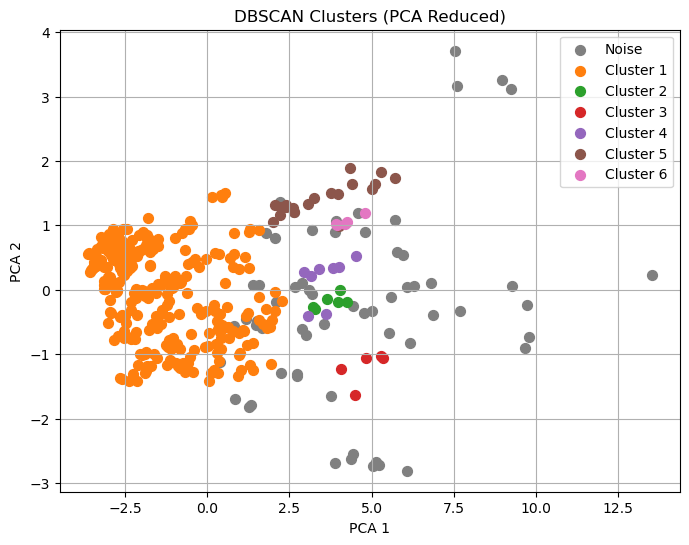

In [12]:
# PCA reduction
X_2d = PCA(n_components=2).fit_transform(X_scaled)

# Unique labels
unique_labels = sorted(set(labels))
n_clusters = len([l for l in unique_labels if l != -1])

# Define colormap (same as your plot)
cmap = plt.get_cmap("tab10")

# Plot
plt.figure(figsize=(8, 6))
for label in unique_labels:
    mask = (labels == label)
    color = 'gray' if label == -1 else cmap(label % 10)
    label_name = "Noise" if label == -1 else f"Cluster {label}"
    plt.scatter(X_2d[mask, 0], X_2d[mask, 1], c=[color], label=label_name, s=50)

plt.title("DBSCAN Clusters (PCA Reduced)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.show()


The PCA visualization makes it clear that DBSCAN was able to extract a meaningful central structure (Cluster 1), while also identifying smaller, compact groups and diverse outliers. The scattered noise points may reflect either biologically unusual individuals or measurement errors. The emergence of many small clusters alongside one dominant group suggests a high degree of variation in bone structure. 



### Cluster and noise counts

Next I look at the number of clusters that DBSCAN found, as well as the number of points it deemed too far from any of these.

In [13]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = np.sum(labels == -1)

print("Clusters found:", n_clusters)
print("Noise points:", n_noise)

Clusters found: 6
Noise points: 62


Because of the high number of noise points, the eps parameter might be too low. So, I run a test to compare the cluster/noise counts obtained by DBSCAN with different eps

### `eps` Parameter Tuning

I ran DBSCAN with several values of the `eps` parameter. As expected:
- **Smaller `eps` values** led to more points being labeled as noise, with fewer and tighter clusters.
- **Larger `eps` values** reduced the number of noise points, but risked merging distinct bird types into the same cluster.

Knowing that there are 6 distinct types of birds in the data set, with much variation without some of them, it seems ill advised to increase eps above 1.0, since that is when cluster count drops below 6. On the other hand, 272 noise points is way too much of the data beeing deemed as outliers, so a good tradeoff value is probably `eps = 0.5` or `eps = 0.7`

In [16]:
for eps in [0.3, 0.5, 0.7, 1.0, 1.2, 1.5]:
    labels = dbscan(X_scaled, eps=eps, min_samples=5)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)
    print(f"eps = {eps:.1f} --> clusters: {n_clusters}, noise points: {n_noise}")


eps = 0.3 --> clusters: 7, noise points: 272
eps = 0.5 --> clusters: 8, noise points: 211
eps = 0.7 --> clusters: 6, noise points: 125
eps = 1.0 --> clusters: 6, noise points: 62
eps = 1.2 --> clusters: 4, noise points: 42
eps = 1.5 --> clusters: 4, noise points: 25


Doing the same thing but for the min_samples parameters shows us that the balance, when eps is set to 0.6, is somewhere between 6 and 8.

In [22]:
for mi in [2,4,6,8,10]:
    labels = dbscan(X_scaled, eps=0.6, min_samples=mi)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)
    print(f"min_samples = {mi:.1f} --> clusters: {n_clusters}, noise points: {n_noise}")


min_samples = 2.0 --> clusters: 40, noise points: 67
min_samples = 4.0 --> clusters: 13, noise points: 139
min_samples = 6.0 --> clusters: 8, noise points: 173
min_samples = 8.0 --> clusters: 6, noise points: 207
min_samples = 10.0 --> clusters: 4, noise points: 232


### More on DBSCAN’s Strengths and Trade-offs
The main advantage of the DBSCAN algorithm over other unsupervised clustering methods is its robustness to noise and outliers. This makes it especially well-suited for biological datasets like the bird bone measurements, where individual variability can lead to atypical data points. Rather than forcing all data into clusters, DBSCAN labels such cases as noise. Sometimes, too many points are labeled as noise, which is why it is good to run tests to see which epsilon parameter provides the best balance.

Another major strength of DBSCAN is that it does not require predefining the number of clusters, unlike K-Means. This is particularly useful when the underlying structure of the data is unknown, as was the case here, we restricted the model's knowledge so that it did not know there were 6 distinct types of birds represented in the data. Instead, DBSCAN was close to finding these 6 distinct groups by itself. Of course, this can lead to a problem of too few clusters, which the other half of the balance needed when tuning the epsilon parameter.

This is the challenge that comes with the flexibility of DBSCAN. The two parameters for the model—eps (the neighborhood radius) and min_samples (the minimum number of points to form a dense region)—can significantly influence the outcome:

- A small eps may result in too many points being marked as noise.

- A large eps may merge distinct clusters into one.

In this project, we found that DBSCAN with a moderate eps (around 0.6) and min_samples of 7.0 produced a useful balance.